# An agent-based model of social support

*Joël Foramitti, 10.02.2022*

This notebook introduces a simple agent-based model to explore the propagation of social support through a population.

In [1]:
import agentpy as ap 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

The agents of the model have one variable `support` which indicates their support for a particular cause.

At every time-step, an agent interacts with their friends as well as some random encounters.

The higher the perceived support amongst their encounters, the higher the likelyhood that the agent will also support the cause.

In [2]:
class Individual(ap.Agent):
    
    def setup(self):
        
        # Initiate a variable support
        # 0 indicates no support, 1 indicates support
        self.support = 0
        
    def adapt_support(self):
        
        # Perceive average support amongst friends and random encounters
        random_encounters = self.model.agents.random(self.p.random_encounters)
        all_encounters = self.friends + random_encounters
        perceived_support = sum(all_encounters.support) / len(all_encounters)
        
        # Adapt own support based on random chance and perceived support
        random_draw = self.model.random.random()  # Draw between 0 and 1
        self.support = 1 if random_draw < perceived_support else 0

At the start of the simulation, the model initiates a population of agents, defines a random network of friendships between these agents, and chooses a random share of agents to be the initial supporters of the cause. 

At every simulation step, agents change their support and the share of supporters is recorded. 

At the end of the model, the cause is designated a success if all agents support it.

In [3]:
class SupportModel(ap.Model):
    
    def setup(self):
        
        # Initiating agents
        self.agents = ap.AgentList(self, self.p.n_agents, Individual)
        
        # Setting up friendships
        graph = nx.watts_strogatz_graph(
            self.p.n_agents, 
            self.p.n_friends, 
            self.p.network_randomness)
        self.network = self.agents.network = ap.Network(self, graph=graph)
        self.network.add_agents(self.agents, self.network.nodes)
        for a in self.agents:
            a.friends = self.network.neighbors(a).to_list()
            
        # Setting up initial supporters
        initial_supporters = int(self.p.initial_support * self.p.n_agents)
        for a in self.agents.random(initial_supporters):
            a.support = 1
        
    def step(self):
        
        # Let every agent adapt their support
        self.agents.adapt_support()

    def update(self):
        
        # Record the share of supporters at each time-step
        self.supporter_share = sum(self.agents.support) / self.p.n_agents
        self.record('supporter_share')
        
    def end(self):
        
        # Report the success of the social movement 
        # at the end of the simulation
        self.success = 1 if self.supporter_share == 1 else 0
        self.model.report('success')

## A single-run simulation

In [4]:
parameters = {
    'steps': 100,
    'n_agents': 100,
    'n_friends': 2,
    'network_randomness': 0.5,
    'initial_support': 0.5, 
    'random_encounters': 1
}

In [5]:
model = SupportModel(parameters)
results = model.run()
success = 'Yes' if model.success else 'No'
print(f'Success: {success}')

Completed: 100 steps
Run time: 0:00:00.174389
Simulation finished
Success: Yes


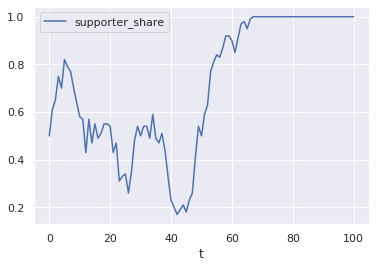

In [6]:
ax = results.variables.SupportModel.plot()

## A multi-run experiment

In [12]:
sample_parameters = {
    'steps': 100,
    'n_agents': 100,
    'n_friends': 2,
    'network_randomness': 0.5,
    'initial_support': ap.Range(0, 1),
    'random_encounters': 1
}

In [13]:
sample = ap.Sample(sample_parameters, n=50)
exp = ap.Experiment(SupportModel, sample, iterations=50)
results = exp.run()

Scheduled runs: 2500
Completed: 2500, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:04:05.299086


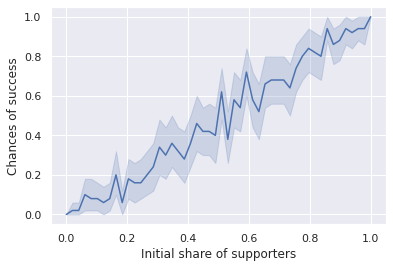

In [16]:
ax = sns.lineplot(
    data=results.arrange_reporters(),
    x='initial_support',
    y='success'
)
ax.set_xlabel('Initial share of supporters')
ax.set_ylabel('Chances of success');

## Questions for discussion

- What happens under different parameter values?
- How does this model compare to real-world dynamics?
- What false conclusions could be made from this model?
- How could the model be improved or extended?